In [15]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
with open('out/df_final.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head(1)

,topic_label,type_of_material_Biography,type_of_material_Brief,type_of_material_Correction,type_of_material_Editorial,type_of_material_First Chapter,type_of_material_Interview,type_of_material_Letter,type_of_material_List,type_of_material_News,...,world,would,write,writer,writing,yankee,yankees,yearold,yet,young
0,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model one: Default SVM model trained on original dataset

In [4]:
X = df.drop('topic_label', axis=1)
y = df['topic_label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC()

# Train the SVM model
model.fit(X_train, y_train)

SVC()

In [5]:
#Evaluate the model on both training and test data to see if the model is overfitting. 


# Predict on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
print("Training Data Performance:")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
print("Test Data Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred))



Training Data Performance:
Classification Report:
              precision    recall  f1-score   support

      Events       0.98      0.83      0.90       342
   Lifestyle       0.95      1.00      0.97      3842
    Politics       0.99      0.90      0.95      1467

    accuracy                           0.96      5651
   macro avg       0.98      0.91      0.94      5651
weighted avg       0.96      0.96      0.96      5651

Test Data Performance:
Classification Report:
              precision    recall  f1-score   support

      Events       1.00      0.82      0.90       104
   Lifestyle       0.92      0.99      0.96       993
    Politics       0.96      0.79      0.87       316

    accuracy                           0.93      1413
   macro avg       0.96      0.87      0.91      1413
weighted avg       0.94      0.93      0.93      1413



### Insights

Given the class imbalance, we are not looking the accuracy score. 


The slight drop in performance metrics (precision, recall, f1-score) from the training data to the test data suggests that the model might be overfitting to the training data. Although the differences are not drastic, this highlights the importance of considering techniques to improve generalization.

Next steps:

Addressing the Imbalance: exploring techniques like SMOTE for balancing could help improve recall for minority classes like Events and Politics.

Model Tuning: Hyperparameter tuning might help in reducing overfitting and improving the generalization of the model. Exploring different kernels, regularization parameters, and class weights could be beneficial.


Overall, the performance of the SVM model with default parameters on the original data, as indicated by the classification reports for both training and test data, can be considered quite good, especially given the challenge of handling an imbalanced dataset. but there is room for improvement in handling imbalanced classes and ensuring the model generalizes well to unseen data.




In [6]:
model_one = SVC(probability=True)

# Train the SVM model
model_one.fit(X_train, y_train)

SVC(probability=True)

In [17]:


def evaluate_model(model, X_train, y_train, X_test, y_test, n_splits=5):
    
    # Initialize cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    
    # Binarize the output labels for multiclass ROC AUC
    y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
    n_classes = y_train_bin.shape[1]
    
    
    # Compute cross-validation ROC AUC score
    cv_scores = cross_val_score(model, np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)), 
                                cv=cv_strategy, scoring='roc_auc_ovr', n_jobs=-1)
    mean_cv_score = cv_scores.mean()
    print(f'Mean CV ROC AUC Score: {mean_cv_score}')
    
    
    # for ROC AUC
    y_proba = model.predict_proba(X_test)

    # Compute ROC AUC score
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')
    print(f'Test Data AUC ROC: {roc_auc}')
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # for classification report and matrix
    y_pred = model.predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


### Model One Evaluation

Mean CV ROC AUC Score: 0.9895296833713028
Test Data AUC ROC: 0.9924028495039604


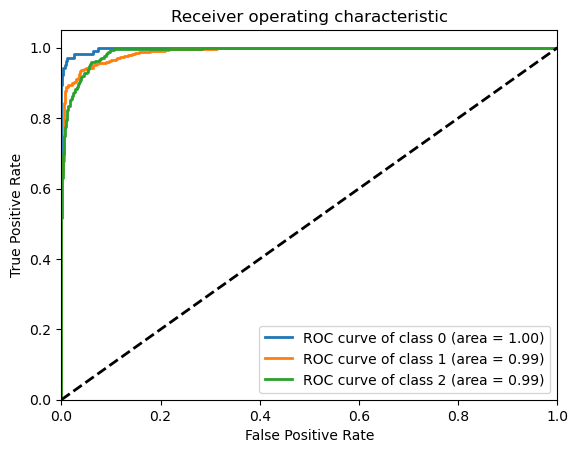

              precision    recall  f1-score   support

      Events       1.00      0.82      0.90       104
   Lifestyle       0.92      0.99      0.96       993
    Politics       0.96      0.79      0.87       316

    accuracy                           0.93      1413
   macro avg       0.96      0.87      0.91      1413
weighted avg       0.94      0.93      0.93      1413



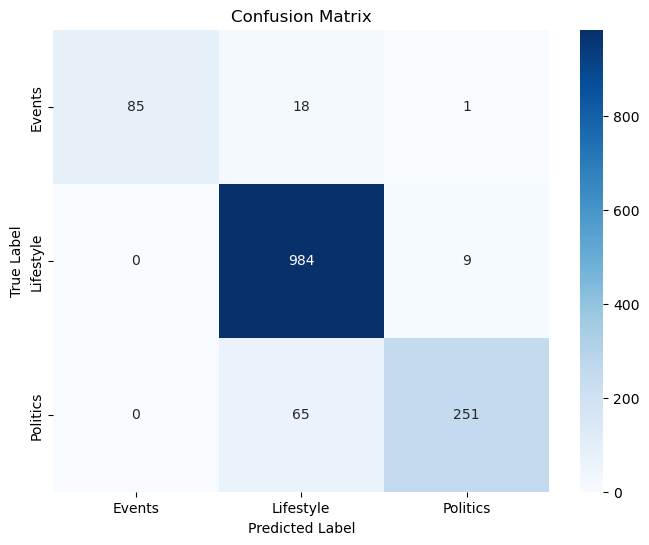

In [18]:
evaluate_model(model_one, X_train, y_train, X_test, y_test)

### Model two: default SVM model trained on SMOTE-processed data

In [19]:
#import smoted datasets
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
smote_Xtrain = load_pickle('out/smote_Xtrain.pkl')
smote_Xtest = load_pickle('out/smote_Xtest.pkl')
smote_ytrain = load_pickle('out/smote_ytrain.pkl')
smote_ytest = load_pickle('out/smote_ytest.pkl')


In [20]:
model_two = SVC(probability=True) 
model_two.fit(smote_Xtrain, smote_ytrain)

SVC(probability=True)

Mean CV ROC AUC Score: 0.9990913164415366
Test Data AUC ROC: 0.9988515554413002


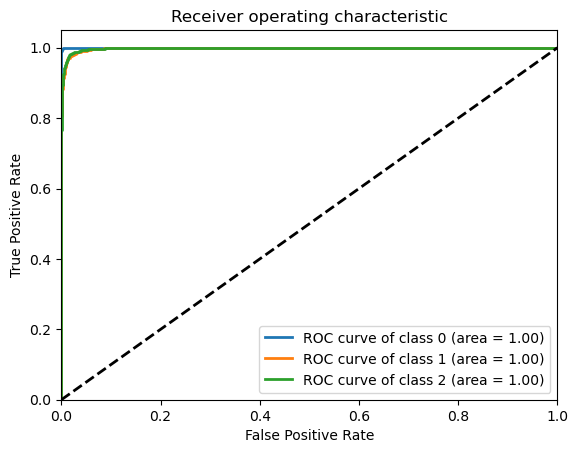

              precision    recall  f1-score   support

      Events       1.00      1.00      1.00      1219
   Lifestyle       0.97      0.97      0.97      1208
    Politics       0.97      0.98      0.97      1200

    accuracy                           0.98      3627
   macro avg       0.98      0.98      0.98      3627
weighted avg       0.98      0.98      0.98      3627



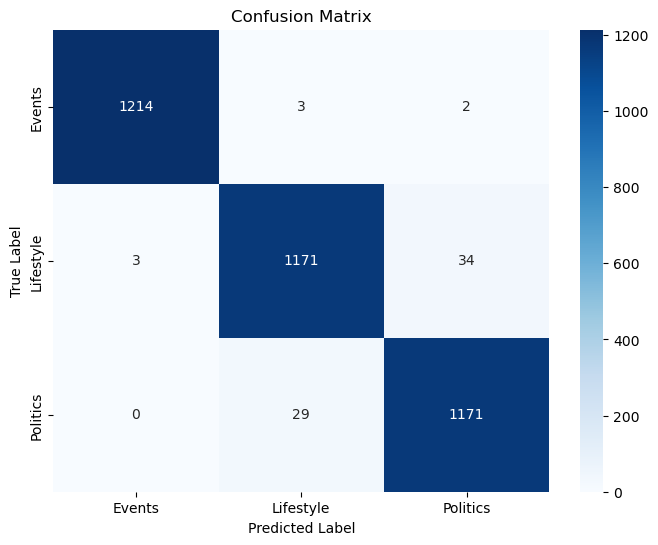

In [21]:
evaluate_model(model_two, smote_Xtrain, smote_ytrain, smote_Xtest, smote_ytest)

### Insights

The AUC ROC score is about 0.999 and the ROC curves for each class are extremely close to the top-left corner of the plot.

The default SVM model trained on the SMOTE-processed data has an almost perfect ability to distinguish between the classes. The high AUC ROC score indicates that the model has a very low false positive rate and a very high true positive rate across all classes. In practical terms, it is rarely misclassifying the different classes of our data.

With such a high score, we might want to evaluate the model further to ensure that the evaluation is correct. Cross-validation on different subsets of the data could help confirm that the model truly has such high predictive power.

### Insights

From the precision score we can see that when the model predicts a class,  it is correct most of the time.

The recall is also high across all classes. This indicates that the model is able to identify the majority of the positive instances correctly.

The high  f1-scores are for all classes suggests a balanced performance between precision and recall, which is especially important in imbalanced datasets.

(The near-perfect metrics across the board suggest that the model is robust and generalizes well to the test data.)

The model exhibits a high degree of accuracy in classifying instances into the correct categories, with particularly outstanding performance in identifying Events.

The minor misclassifications between Lifestyle and Politics suggest that there might be some overlap or similarities between these classes that the model occasionally confuses.



### Model Three: Default SVM model trained Stratified Data Set

using Stratified Sampling as another method to handle the imbalanced dataset

In [22]:
#Get stratified data set
with open("out/train_test_data.pkl", "rb") as f:
    data = pickle.load(f)

X_s_train = data['X_train']
X_s_test = data['X_test']
y_s_train = data['y_train']
y_s_test = data['y_test']

In [23]:
model_three = SVC(probability=True) 
model_three.fit(X_s_train, y_s_train)

SVC(probability=True)

Mean CV ROC AUC Score: 0.9906330933858966
Test Data AUC ROC: 0.9895710061195396


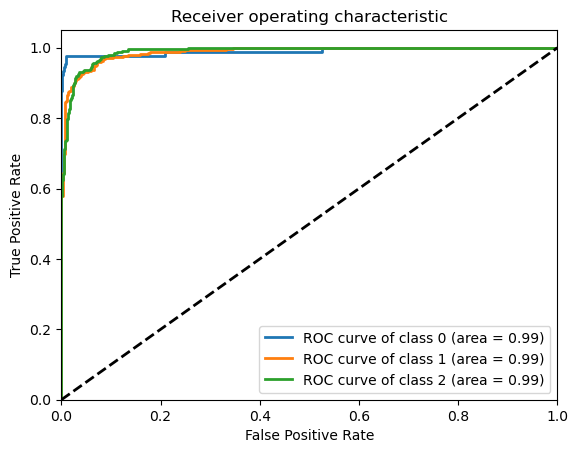

              precision    recall  f1-score   support

      Events       1.00      0.78      0.87        89
   Lifestyle       0.92      0.98      0.95       967
    Politics       0.95      0.82      0.88       357

    accuracy                           0.93      1413
   macro avg       0.96      0.86      0.90      1413
weighted avg       0.93      0.93      0.93      1413



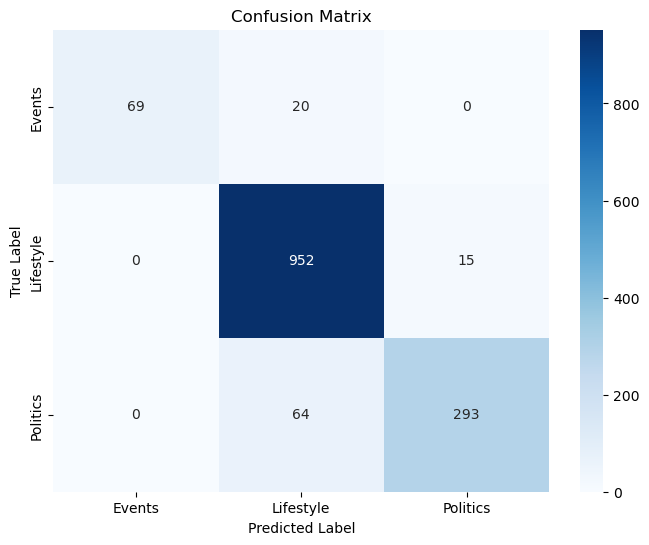

In [24]:
evaluate_model(model_three, X_s_train, y_s_train, X_s_test, y_s_test)

###  Compare the performance of the three models

#### Based on the metric scores. 


Model One:

This model has good precision across all classes but has lower recall for the 'Events' and 'Politics' classes, which indicates it struggles more with identifying these classes compared to 'Lifestyle'.

The AUC ROC score is high (0.992), indicating a good ability to distinguish between classes.

Model Two:

The performance metrics for this model are exceptional, with perfect precision for 'Events' and very high precision and recall for 'Lifestyle' and 'Politics'.

An AUC ROC of nearly 1 (0.999) suggests an outstanding ability to differentiate between classes.

Model Three:

The precision is consistent across classes, similar to Model One. However, the recall for 'Events' and 'Politics' is somewhat lower, indicating some challenges in correctly identifying all true cases for these classes.


The AUC ROC is high at 0.990 but slightly lower than Model One, indicating a very good but not quite as excellent discriminative ability as the other models.

Insights

Model Two significantly improves the model's ability to identify the minority classes ('Events' and 'Politics'), as evidenced by the perfect or near-perfect recall scores and the very high AUC ROC score. This indicates that the synthetic oversampling technique effectively mitigates the class imbalance issue.

Model Three maintains the class distribution during splitting, which helps to ensure that the evaluation is fair and that each class's representation is preserved. The performance is quite similar to Model One, indicating that stratification alone without oversampling might not be sufficient to address the imbalance in this particular case.

Model One on the original data performs well but not as well as the model trained on SMOTE data, particularly in terms of recall for the 'Events' and 'Politics' classes.

The F1-Score is a crucial metric when comparing these models, especially since it balances precision and recall. Model Two's uniform and high F1-scores across all classes suggest that it is the most balanced model in terms of performance.



Model Two trained on SMOTE-processed data appears to be the superior model based on these metrics, with the best overall and class-specific performance.

For practical deployment, Model Two's performance indicates that it would likely be the most effective at classifying new, unseen data while maintaining fairness across classes.

It's worth noting that high performance, especially with perfect metrics, should be scrutinized to confirm that the results are valid and reproducible.



### Best Model Justification

From the evaluation, it's evident that the model trained on the original data performs sufficiently well, closely matched by the model trained on the stratified dataset. Although the model trained on SMOTE-processed data exhibits near-perfect metrics, the difference compared to the model trained on the original data is not significantly large. Hence, we designate the model trained on the original data as the "best" SVM model. Training the SVM on the original dataset is a judicious choice for real-world applications, offering a perfect blend of performance and practicality. This choice is informed by its accurate reflection of true data distributions and its straightforward interpretability. Despite the appealing metrics of the SMOTE-processed model, there's a risk of overfitting, with the possibility that such outstanding results might not extend to new, unseen data. Moreover, the original model facilitates easier maintenance and updates, forgoing the need for synthetic data generation, thus presenting a more straightforward approach as new real-world data becomes available. 
